In [2]:
#import
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 300)
import numpy as np
import os
import time

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster import hierarchy as hc

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from lightgbm import LGBMRegressor

In [3]:
cus = pd.read_csv("open/cus_info.csv")
iem = pd.read_csv("open/iem_info.csv")
hist = pd.read_csv("open/stk_bnc_hist.csv")
train = pd.read_csv("open/stk_hld_train.csv")
test = pd.read_csv("open/stk_hld_test.csv")

submission = pd.read_csv("open/sample_submission.csv")

train["hist_d"] = train["hold_d"]*0.5
train.hist_d = np.trunc(train["hist_d"])

train.head()

,act_id,iem_cd,byn_dt,hold_d,hist_d
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A006360,20180726,11,5.00
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005930,20180131,80,40.00
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005070,20180517,5,2.00
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A003520,20201112,22,11.00
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A002310,20180905,324,162.00


plt.figure(figsize=(12,8))
sns.barplot(x=train['hist_d'].unique(),
            y=train['hist_d'].value_counts())
train['hist_d'].value_counts().plot.bar()
- 생략

In [4]:
#데이터 merge
train_data = pd.merge(train, cus, how = "left", on = ["act_id"])
train_data = pd.merge(train_data, iem, how = "left", on = ["iem_cd"])

test_data = pd.merge(test, cus, how = "left", on = ["act_id"])
test_data = pd.merge(test_data, iem, how = "left", on = ["iem_cd"])
train_data.head()

,act_id,iem_cd,byn_dt,hold_d,hist_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A006360,20180726,11,5.00,1,9,3,2,2,9,5,5,8,GS건설,1,1,1
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005930,20180131,80,40.00,1,9,3,2,2,9,5,5,8,삼성전자,9,1,1
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005070,20180517,5,2.00,1,9,3,2,2,9,5,5,8,코스모신소재,12,2,99
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A003520,20201112,22,11.00,1,9,3,2,2,9,5,5,8,영진약품,8,2,1
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A002310,20180905,324,162.00,1,9,3,2,2,9,5,5,8,아세아제지,10,3,99


In [5]:
# train_data에서 Y값을 추출한 후 hold_d column을 지워주겠습니다.
train_label = train_data["hold_d"]
train_data.drop(["hold_d"], axis = 1, inplace = True)

hist["stk_p"] = hist["tot_aet_amt"] / hist["bnc_qty"]
hist = hist.fillna(0)

train_data = pd.merge(train_data, hist, how = "left", on = ["act_id", "iem_cd"])
train_data = train_data[(train_data["byn_dt"] == train_data["bse_dt"])]
train_data.reset_index(drop = True, inplace = True)

test_data = pd.merge(test_data, hist, how = "left", on = ["act_id", "iem_cd"])
test_data = test_data[(test_data["byn_dt"] == test_data["bse_dt"])]
test_data.reset_index(drop = True, inplace = True)

train_data = train_data.drop(["act_id", "iem_cd", "byn_dt", "bse_dt"], axis = 1)
test_data = test_data.drop(["act_id", "iem_cd", "byn_dt", "submit_id", "hold_d", "bse_dt"], axis = 1)

L_encoder = LabelEncoder()
L_encoder.fit(iem["iem_krl_nm"])
train_data["iem_krl_nm"] = L_encoder.transform(train_data["iem_krl_nm"])
test_data["iem_krl_nm"] = L_encoder.transform(test_data["iem_krl_nm"])

train_data.head()

,hist_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,stk_par_pr,stk_p
0,5.00,1,9,3,2,2,9,5,5,8,101,1,1,1,274.00,11782000.00,5000.00,43000.00
1,40.00,1,9,3,2,2,9,5,5,8,1361,9,1,1,2.00,4990000.00,5000.00,2495000.00
2,2.00,1,9,3,2,2,9,5,5,8,2530,12,2,99,786.00,14619600.00,1000.00,18600.00
3,11.00,1,9,3,2,2,9,5,5,8,1969,8,2,1,60.00,462000.00,500.00,7700.00
4,162.00,1,9,3,2,2,9,5,5,8,1696,10,3,99,183.00,8125200.00,5000.00,44400.00


In [11]:
print(train_label.head())

0     11
1     80
2      5
3     22
4    324
Name: hold_d, dtype: int64


In [7]:
train_data.reset_index(drop = True, inplace=True)
train_label.reset_index(drop = True, inplace=True)

In [8]:
train_data.shape

(681472, 18)

In [9]:
train_data.dtypes

hist_d                  float64
sex_dit_cd                int64
cus_age_stn_cd            int64
ivs_icn_cd                int64
cus_aet_stn_cd            int64
mrz_pdt_tp_sgm_cd         int64
lsg_sgm_cd                int64
tco_cus_grd_cd            int64
tot_ivs_te_sgm_cd         int64
mrz_btp_dit_cd            int64
iem_krl_nm                int32
btp_cfc_cd                int64
mkt_pr_tal_scl_tp_cd      int64
stk_dit_cd                int64
bnc_qty                 float64
tot_aet_amt             float64
stk_par_pr              float64
stk_p                   float64
dtype: object

In [12]:
input_var = list(train_data.columns)

Xtrain = train_data[input_var] # 학습 데이터 선택
Ytrain = train_label # target 값인 Y 데이터 선택

Xtest = test_data[input_var] # 시험 데이터도 선택

In [14]:
from xgboost import XGBRegressor

model = XGBRegressor(random_state=110, verbosity=0, nthread=23, n_estimators=980, max_depth=4)
kfold = KFold(n_splits=8, shuffle=True, random_state=777)
n_iter = 0
cv_score = []

def rmse(target, pred):
    return np.sqrt(np.sum(np.power(target - pred, 2)) / np.size(pred))

In [20]:
models = []

folds = KFold(n_splits=10)

for train_index, test_index in kfold.split(Xtrain, Ytrain):
    # K Fold가 적용된 train, test 데이터를 불러온다
    X_train, X_test = Xtrain.iloc[train_index,:], Xtrain.iloc[test_index, :]
    Y_train, Y_test = Ytrain.iloc[train_index], Ytrain.iloc[test_index]
    
    # 모델 학습과 예측 수행
    model.fit(X_train, Y_train)
    pred = model.predict(X_test)
    print(pred)
    
    # 정확도 RMSE 계산
    n_iter += 1
    score = rmse(Y_test, pred)
    print(score)
    cv_score.append(score)
print('\n교차 검증별 RMSE :', np.round(cv_score, 4))
print('평균 검증 RMSE :', np.mean(cv_score))

[ 98.535545   80.521164  128.46164   ...   8.463418    1.0139648
   2.3736613]
0.4299575233922654
[80.69417    22.406933   12.343326   ...  2.3890965  12.414394
  0.93520063]
0.4242304242110091
[10.519802  98.5227    30.482826  ... 80.51396    2.3713708  1.0307162]
0.4684310279841886
[ 4.3831306  1.0077381 10.428954  ...  0.9871708  1.0092849  0.952615 ]
0.43785236023477314
[  1.0070834  152.45169     10.471325   ...   0.99222213   0.9355092
   1.0047915 ]
0.44279180127614537
[ 2.3920772 20.47433    2.373239  ...  2.314562   1.0004892  0.9839712]
0.4271732146645374
[324.7783      22.47079     40.578484   ...  42.52589      0.99525315
   1.0042139 ]
0.4307223419957202
[0.992371  8.431723  6.45775   ... 1.0004253 4.4519353 1.0121604]
0.4294630405263496

교차 검증별 RMSE : [0.43   0.4242 0.4684 0.4379 0.4428 0.4272 0.4307 0.4295 0.43   0.4242
 0.4684 0.4379 0.4428 0.4272 0.4307 0.4295]
평균 검증 RMSE : 0.43632771678562365


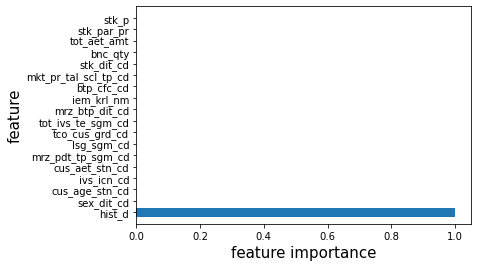

0.99999994

In [21]:
n_feature = X_train.shape[1] #주어진 변수들의 갯수를 구함
index = np.arange(n_feature)

plt.barh(index, model.feature_importances_, align='center') #
plt.yticks(index, input_var)
plt.ylim(-1, n_feature)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()
np.sum(model.feature_importances_)

result = model.predict(Xtest) # 시험 데이터 예측

test_data['hold_d'] = result # 예측 결과로 추가
test_data[['act_id', 'hold_d']].to_csv('result.csv',index=False, float_format='%.14f') # csv로 변환

In [24]:
result = []
for i in models:
    result.append(i.predict(test_data))
predict = np.mean(result, axis = 0)
predict

submission["hold_d"] = np.round(predict)

submission.loc[submission.hold_d-test.hist_d>146,'hold_d']=test.hist_d+146
submission.to_csv("dacon_baseline.csv", index = False)